<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-258/blob/master/Assignments/Assignment%206/Assignment6part_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autograd framework using Numpy

In [ ]:
import numpy as np

# Autograd Framework

In [ ]:
# Define the class Tensor
class Tensor (object):
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = FloatTensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "softmax":
                    self.creators[0].backward(self.grad)

                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def shape(self):
      return self.data.shape
    
    def softmax(self):
        x = self.data - self.data.max(axis=1, keepdims=True)
        y = np.exp(x)
        v = y / y.sum(axis=1, keepdims=True)

        if(self.autograd):
            return Tensor(v,
                          autograd=True,
                          creators=[self],
                          creation_op="softmax")
        return Tensor(v)

    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())

In [ ]:
class AutoGradTensor:

    def __init__(self, data, autograd=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.autograd = autograd
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    # Use Python Decorator @property to properly set the  
    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.autograd:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.autograd:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'AutoGradTensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

    def model(self, x):
        if(self.autograd):
            return AutoGradTensor(self.data.dot(x.data))
        return AutoGradTensor(self.data.dot(x.data))


In [ ]:
class Operation:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

In [ ]:
class Add(Operation):

    '''Summation operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data + y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

In [ ]:
class Multiplication(Operation):
    '''Multiplication operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data * y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            self.x.add_grad(AutoGradTensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            self.y.add_grad(AutoGradTensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [ ]:
def add(x, y):
  z = x + y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [1, 1, 1, 1, 1])
  return z

In [ ]:
def subtract(x, y):
  z = x - y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [-1, -1, -1, -1, -1])
  return z

## Build Network

In [ ]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self, x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

# Create Softmax Cross Entropy Activation Function
class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
    # Setting the grad = True will call the autograd function in AutoGradTensor
    def backward(self, grad=True):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input


In [ ]:
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))



[ True  True  True  True  True]


In [ ]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

## unit tests

In [ ]:
def _test_add():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a + b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # c = a + b
  # dc/da = 1
  # dc/db = 1
  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [1, 1, 1, 1, 1])

def _test_sub():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  c = a - b
  c.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # c = a - b
  # dc/da = 1
  # dc/db = -1
  np.testing.assert_array_equal(a.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(b.grad.data, [-1, -1, -1, -1, -1])

def _test_mul():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  e = a * b
  e.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # d = ab
  # de/da = b
  # de/db = a
  np.testing.assert_array_equal(a.grad.data, [2, 2, 2, 2, 2])
  np.testing.assert_array_equal(b.grad.data, [1, 2, 3, 4, 5])

def _test_neg():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)

  d = -a
  d.backward(Tensor(np.array([1,1,1,1,1])))

  # d = -a
  # dd/da = -1
  np.testing.assert_array_equal(a.grad.data, [-1, -1, -1, -1, -1])

def _test_softmax():
  a = Tensor([[500, 4, 3, 2, 1]])
  np.testing.assert_array_equal(np.around(a.softmax().data, decimals=1), [[1, 0, 0, 0, 0]])

def _test_combo():
  a = Tensor([1, 2, 3, 4, 5], autograd=True)
  b = Tensor([2, 2, 2, 2, 2], autograd=True)
  c = Tensor([5, 4, 3, 2, 1], autograd=True)

  d = a * (-b)
  e = (-b) + c
  f = d + e
  f.backward(Tensor(np.array([1, 1, 1, 1, 1])))

  # f = a * (-b) + (-b) + c 
  #   = -ab - b + c
  # df/da = -b
  # df/db = -a - 1
  # df/dc = 1
  np.testing.assert_array_equal(a.grad.data, [-2, -2, -2, -2, -2])
  np.testing.assert_array_equal(b.grad.data, [-2, -3, -4, -5, -6])
  np.testing.assert_array_equal(c.grad.data, [1, 1, 1, 1, 1])


_test_add()
_test_sub()
_test_mul()
_test_neg()
_test_softmax()
_test_combo()

# MNIST Classifier

## Import Libraries

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Visualizing the train dataset.


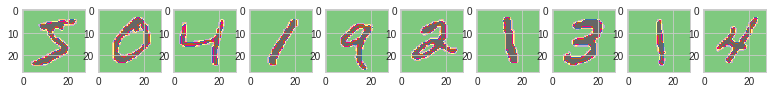

In [ ]:
def visualize_N_elems_of_dataset(dataset, N, name):
  print("Visualizing the " + name + " dataset.")
  fig = plt.figure(figsize=plt.figaspect(0.3))

  # Plot N elems of the dataset
  for image in range(0, N):
    ax = fig.add_subplot(1, 10, image+1)
    ax.imshow(dataset[image], cmap='Accent')

visualize_N_elems_of_dataset(X_train, 10, "train")

Visualizing the test dataset.


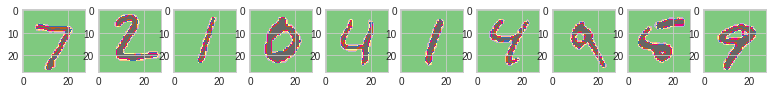

In [ ]:
visualize_N_elems_of_dataset(X_test, 10, "test")


## Preprocessing

In [ ]:
from keras.utils import np_utils
X_train = X_train.reshape(X_train.shape[0], 28*28) / 255.
X_test = X_test.reshape(X_test.shape[0], 28*28) / 255.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

## Train Test Split

In [ ]:
X_train = X_train[:10]
y_train = y_train[:10]
X_test = X_test[:100]
y_test = y_test[:100]
input_dim = X_train.shape[1]
num_classes = y_test.shape[1]


## Model Fit and Prediction

In [ ]:
data = Tensor(X_train, autograd=True)
expected = Tensor(y_train, autograd=True)

weights = []
weights.append(Tensor(np.random.rand(input_dim, 64), autograd=True))
weights.append(Tensor(np.random.rand(64, 10), autograd=True))
learning_rate = 0.0001

# fit, predict
for i in range(10):
  # Predict
  predicted = data.mm(weights[0]).mm(weights[1]).softmax()
  loss = ((predicted - expected) * (predicted - expected)).sum(0)
  loss.backward(Tensor(np.ones_like(loss.data)))
  for wts in weights:
    wts.data -= wts.grad.data*learning_rate
    wts.grad.data = wts.grad.data*0
    print(np.mean(loss.data))

1.4
1.4
1.5999895762000416
1.5999895762000416
1.999998237208946
1.999998237208946
1.670283723260137
1.670283723260137
1.7999940934432495
1.7999940934432495
1.77767400391717
1.77767400391717
1.799996870528323
1.799996870528323
1.5036613840643
1.5036613840643
1.5999999999999999
1.5999999999999999
1.8
1.8


In [ ]:
# Load MNIST using Pytorch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        # convert the image to Numpy array
        x = img.view(2,-1).numpy()

        y = mm(x)
        # convert the label to numpy array
        _loss = loss(y, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Processing...
Done!
1.001185881281142
---------
138.3596725027164
---------
135.9719438532638
---------
118.81448169275134
---------
113.90114150994239
---------
129.86175131661378
---------
104.29640946484989
---------
113.8305009407143
---------
106.58319542453707
---------
96.22265317967232
---------
89.74169065666568
---------
116.27320056115505
---------
91.90410675984738
---------
84.91795540647198
---------
99.51846953651331
---------
92.62151265845709
---------
86.08415906354966
---------
82.34829069378544
---------
79.38582453406786
---------
86.12200684618062
---------
70.80567655582648
---------
81.80716159122463
---------
81.84358363008636
---------
90.00102276016435
---------
74.24139314858435
---------
75.95724193185607
---------
72.31612274198015
---------
74.13131009949576
---------
68.46300089284279
---------
62.519613210058395
---------
68.47847672205474
---------
71.69660004060071
---------